I. Querying the SQL database

II. Calculating summary statistics (team wins and losses; total number of goals scored) + histogram of each team's wins and losses

III. Getting the weather data from the DarkSky API + calculating the team's win percentage on days when it was raining

IV. Loading the data into MongoDB

I. SQL database

In [147]:
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import sqlite3 

conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

Inspecting the first table, 'matches'

In [2]:
cur.execute("""SELECT * 
                FROM Matches;""")

df1 = pd.DataFrame(cur.fetchall())

df1.columns = [x[0] for x in cur.description]
df1.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


Table: Matches Match_ID (int): unique ID per match Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League) Season (int): Season the match took place in (usually covering the period of August till May of the following year) Date (str): Date of the match HomeTeam (str): Name of the home team AwayTeam (str): Name of the away team FTHG (int) (Full Time Home Goals): Number of goals scored by the home team FTAG (int) (Full Time Away Goals): Number of goals scored by the away team FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

Selecting all the information from the matches table during the 2011 season for teams in the Bundesliga only

In [3]:
cur.execute("""SELECT * 
                FROM Matches
                WHERE season = '2011' AND Div != 'E0';""")

df2 = pd.DataFrame(cur.fetchall())

df2.columns = [x[0] for x in cur.description]
df2.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


Selecting individual dates from which to extract weather information based on dates on which bundesliga teams played.

In [4]:
cur.execute("""SELECT DISTINCT Date
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0'
                ORDER BY Date ASC;""")

dates = pd.DataFrame(cur.fetchall())

dates.columns = [x[0] for x in cur.description]
dates.head()

,Date
0,2011-07-15
1,2011-07-16
2,2011-07-17
3,2011-07-18
4,2011-07-22


Selecting relevant data (match_ID, season, date of match, home team, away team, home team goals, away team goals and information about the match) from the matches table during the 2011 season for the bundesliga.

In [5]:
cur.execute("""SELECT Match_ID, Div, Season, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR
            FROM Matches
            WHERE season = '2011' AND Div != 'E0';""")

df3 = pd.DataFrame(cur.fetchall())

df3.columns = [x[0] for x in cur.description]
df3.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


Focus: team wins and losses

Investigating the number of matches where the home team won.

In [6]:
cur.execute("""SELECT DISTINCT HomeTeam, Match_ID, Div, Season, Date, FTHG, FTR
            FROM Matches
            WHERE season = '2011' AND FTR = 'H' AND Div != 'E0'
            GROUP BY HomeTeam;""")

home_wins = pd.DataFrame(cur.fetchall())

home_wins.columns = [x[0] for x in cur.description]
home_wins.head()


,HomeTeam,Match_ID,Div,Season,Date,FTHG,FTR
0,Aachen,1247,D2,2011,2012-04-29,1,H
1,Augsburg,1189,D1,2011,2012-03-31,2,H
2,Bayern Munich,1178,D1,2011,2011-12-16,3,H
3,Bochum,1154,D2,2011,2011-09-25,2,H
4,Braunschweig,1347,D2,2011,2011-11-27,4,H


Checking the number of wins for the home team in 2011

In [7]:
cur.execute("""SELECT HomeTeam as HOMETEAM, COUNT(FTR) as home_wins
            FROM Matches
            WHERE season = '2011' AND FTR = 'H' AND Div != 'E0'
            GROUP BY HomeTeam;""")

home_wins = pd.DataFrame(cur.fetchall())

home_wins.columns = [x[0] for x in cur.description]
home_wins

,HOMETEAM,home_wins
0,Aachen,4
1,Augsburg,6
2,Bayern Munich,14
3,Bochum,7
4,Braunschweig,6
5,Cottbus,4
6,Dortmund,14
7,Dresden,8
8,Duisburg,8
9,Ein Frankfurt,11


Checking the number of losses for the home team in 2011

In [8]:
cur.execute("""SELECT HomeTeam as hometeam, COUNT(FTR) as home_losses
            FROM Matches
            WHERE season = '2011' AND FTR = 'A' AND Div != 'E0'
            GROUP BY HomeTeam;""")

home_losses = pd.DataFrame(cur.fetchall())

home_losses.columns = [x[0] for x in cur.description]
home_losses

,hometeam,home_losses
0,Aachen,7
1,Augsburg,4
2,Bayern Munich,2
3,Bochum,7
4,Braunschweig,3
5,Cottbus,5
6,Dortmund,1
7,Dresden,4
8,Duisburg,7
9,Ein Frankfurt,1


There is one row missing in the home_losses table: Hannover does not appear in it. This means Hannover did not suffer any losses when it played as a home team. 

We can amend the home_wins query, remove the entry for Hannover, and then reinsert the data from Hannover after we have merged the two tables for home team wins and home team losses.

In [9]:
cur.execute("""SELECT HomeTeam as HOMETEAM, COUNT(FTR) as home_wins
            FROM Matches
            WHERE season = '2011' AND FTR = 'H' AND Div != 'E0' AND HomeTeam != 'Hannover'
            GROUP BY HomeTeam;""")

home_wins2 = pd.DataFrame(cur.fetchall())

home_wins2.columns = [x[0] for x in cur.description]
home_wins2

,HOMETEAM,home_wins
0,Aachen,4
1,Augsburg,6
2,Bayern Munich,14
3,Bochum,7
4,Braunschweig,6
5,Cottbus,4
6,Dortmund,14
7,Dresden,8
8,Duisburg,8
9,Ein Frankfurt,11


In [10]:
home_wins_losses = pd.concat([home_wins2,home_losses], axis = 1)

In [11]:
home_wins_losses

,HOMETEAM,home_wins,hometeam,home_losses
0,Aachen,4,Aachen,7
1,Augsburg,6,Augsburg,4
2,Bayern Munich,14,Bayern Munich,2
3,Bochum,7,Bochum,7
4,Braunschweig,6,Braunschweig,3
5,Cottbus,4,Cottbus,5
6,Dortmund,14,Dortmund,1
7,Dresden,8,Dresden,4
8,Duisburg,8,Duisburg,7
9,Ein Frankfurt,11,Ein Frankfurt,1


In [12]:
Hannover = pd.DataFrame({"HOMETEAM":['Hannover'], 
                    "home_wins":[10], "hometeam":['Hannover'], "home_losses":[0]})

In [13]:
Home_Wins_Losses = home_wins_losses.append(Hannover, ignore_index = True)

Checking the number of wins for the away teams in 2011

In [14]:
cur.execute("""SELECT AwayTeam as AWAYTEAM, COUNT(FTR) as away_wins
            FROM Matches
            WHERE season = '2011' AND FTR = 'A' AND Div != 'E0'
            GROUP BY AwayTeam;""")

away_wins = pd.DataFrame(cur.fetchall())

away_wins.columns = [x[0] for x in cur.description]
away_wins

,AWAYTEAM,away_wins
0,Aachen,2
1,Augsburg,2
2,Bayern Munich,9
3,Bochum,3
4,Braunschweig,4
5,Cottbus,4
6,Dortmund,11
7,Dresden,4
8,Duisburg,2
9,Ein Frankfurt,9


In [15]:
cur.execute("""SELECT AwayTeam as awayteam, COUNT(FTR) as away_losses
            FROM Matches
            WHERE season = '2011' AND FTR = 'H' AND Div != 'E0'
            GROUP BY AwayTeam;""")

away_losses = pd.DataFrame(cur.fetchall())

away_losses.columns = [x[0] for x in cur.description]
away_losses

,awayteam,away_losses
0,Aachen,8
1,Augsburg,8
2,Bayern Munich,5
3,Bochum,10
4,Braunschweig,6
5,Cottbus,10
6,Dortmund,2
7,Dresden,9
8,Duisburg,8
9,Ein Frankfurt,5


In order for our data sets to match, we must delete the entries from Hannover above and append them to our new dataframe.

In [16]:
cur.execute("""SELECT AwayTeam as AWAYTEAM, COUNT(FTR) as away_wins
            FROM Matches
            WHERE season = '2011' AND FTR = 'A' AND Div != 'E0' AND AwayTeam != 'Hannover'
            GROUP BY AwayTeam;""")

away_wins2 = pd.DataFrame(cur.fetchall())

away_wins2.columns = [x[0] for x in cur.description]
away_wins2

,AWAYTEAM,away_wins
0,Aachen,2
1,Augsburg,2
2,Bayern Munich,9
3,Bochum,3
4,Braunschweig,4
5,Cottbus,4
6,Dortmund,11
7,Dresden,4
8,Duisburg,2
9,Ein Frankfurt,9


In [17]:
cur.execute("""SELECT AwayTeam as awayteam, COUNT(FTR) as away_losses
            FROM Matches
            WHERE season = '2011' AND FTR = 'H' AND Div != 'E0' AND awayteam != 'Hannover'
            GROUP BY AwayTeam;""")

away_losses2 = pd.DataFrame(cur.fetchall())

away_losses2.columns = [x[0] for x in cur.description]
away_losses2

,awayteam,away_losses
0,Aachen,8
1,Augsburg,8
2,Bayern Munich,5
3,Bochum,10
4,Braunschweig,6
5,Cottbus,10
6,Dortmund,2
7,Dresden,9
8,Duisburg,8
9,Ein Frankfurt,5


In [18]:
away_wins_losses = pd.concat([away_wins2,away_losses2], axis = 1)

In [19]:
away_wins_losses

,AWAYTEAM,away_wins,awayteam,away_losses
0,Aachen,2,Aachen,8
1,Augsburg,2,Augsburg,8
2,Bayern Munich,9,Bayern Munich,5
3,Bochum,3,Bochum,10
4,Braunschweig,4,Braunschweig,6
5,Cottbus,4,Cottbus,10
6,Dortmund,11,Dortmund,2
7,Dresden,4,Dresden,9
8,Duisburg,2,Duisburg,8
9,Ein Frankfurt,9,Ein Frankfurt,5


In [20]:
Hannover = pd.DataFrame({"AWAYTEAM":['Hannover'], 
                    "away_wins":[2], "awayteam":['Hannover'], "away_losses":[10]})

In [21]:
Away_Wins_Losses = away_wins_losses.append(Hannover, ignore_index = True)

In [22]:
total_wins_losses = pd.concat([Home_Wins_Losses,Away_Wins_Losses], axis = 1)

In [23]:
total_wins_losses

,HOMETEAM,home_wins,hometeam,home_losses,AWAYTEAM,away_wins,awayteam,away_losses
0,Aachen,4,Aachen,7,Aachen,2,Aachen,8
1,Augsburg,6,Augsburg,4,Augsburg,2,Augsburg,8
2,Bayern Munich,14,Bayern Munich,2,Bayern Munich,9,Bayern Munich,5
3,Bochum,7,Bochum,7,Bochum,3,Bochum,10
4,Braunschweig,6,Braunschweig,3,Braunschweig,4,Braunschweig,6
5,Cottbus,4,Cottbus,5,Cottbus,4,Cottbus,10
6,Dortmund,14,Dortmund,1,Dortmund,11,Dortmund,2
7,Dresden,8,Dresden,4,Dresden,4,Dresden,9
8,Duisburg,8,Duisburg,7,Duisburg,2,Duisburg,8
9,Ein Frankfurt,11,Ein Frankfurt,1,Ein Frankfurt,9,Ein Frankfurt,5


In [24]:
total_wins_losses['total_wins_overall'] = total_wins_losses['home_wins'] + total_wins_losses['away_wins']

In [25]:
total_wins_losses

,HOMETEAM,home_wins,hometeam,home_losses,AWAYTEAM,away_wins,awayteam,away_losses,total_wins_overall
0,Aachen,4,Aachen,7,Aachen,2,Aachen,8,6
1,Augsburg,6,Augsburg,4,Augsburg,2,Augsburg,8,8
2,Bayern Munich,14,Bayern Munich,2,Bayern Munich,9,Bayern Munich,5,23
3,Bochum,7,Bochum,7,Bochum,3,Bochum,10,10
4,Braunschweig,6,Braunschweig,3,Braunschweig,4,Braunschweig,6,10
5,Cottbus,4,Cottbus,5,Cottbus,4,Cottbus,10,8
6,Dortmund,14,Dortmund,1,Dortmund,11,Dortmund,2,25
7,Dresden,8,Dresden,4,Dresden,4,Dresden,9,12
8,Duisburg,8,Duisburg,7,Duisburg,2,Duisburg,8,10
9,Ein Frankfurt,11,Ein Frankfurt,1,Ein Frankfurt,9,Ein Frankfurt,5,20


In [26]:
total_wins_losses['total_losses_overall'] = total_wins_losses['home_losses'] + total_wins_losses['away_losses']

In [27]:
total_wins_losses

,HOMETEAM,home_wins,hometeam,home_losses,AWAYTEAM,away_wins,awayteam,away_losses,total_wins_overall,total_losses_overall
0,Aachen,4,Aachen,7,Aachen,2,Aachen,8,6,15
1,Augsburg,6,Augsburg,4,Augsburg,2,Augsburg,8,8,12
2,Bayern Munich,14,Bayern Munich,2,Bayern Munich,9,Bayern Munich,5,23,7
3,Bochum,7,Bochum,7,Bochum,3,Bochum,10,10,17
4,Braunschweig,6,Braunschweig,3,Braunschweig,4,Braunschweig,6,10,9
5,Cottbus,4,Cottbus,5,Cottbus,4,Cottbus,10,8,15
6,Dortmund,14,Dortmund,1,Dortmund,11,Dortmund,2,25,3
7,Dresden,8,Dresden,4,Dresden,4,Dresden,9,12,13
8,Duisburg,8,Duisburg,7,Duisburg,2,Duisburg,8,10,15
9,Ein Frankfurt,11,Ein Frankfurt,1,Ein Frankfurt,9,Ein Frankfurt,5,20,6


The table above shows the number of team wins and losses overall in the bundesliga in 2011.

In [28]:
total_wins_losses.drop(['home_wins', 'hometeam', 'home_losses', 'AWAYTEAM', 'away_wins', 'awayteam', 'away_losses'], axis=1)

,HOMETEAM,total_wins_overall,total_losses_overall
0,Aachen,6,15
1,Augsburg,8,12
2,Bayern Munich,23,7
3,Bochum,10,17
4,Braunschweig,10,9
5,Cottbus,8,15
6,Dortmund,25,3
7,Dresden,12,13
8,Duisburg,10,15
9,Ein Frankfurt,20,6


Bar plot showing the total number of wins and losses for all teams.

In [134]:
list_wins = list(total_wins_losses['total_wins_overall'])

In [136]:
list_losses = list(total_wins_losses['total_losses_overall'])

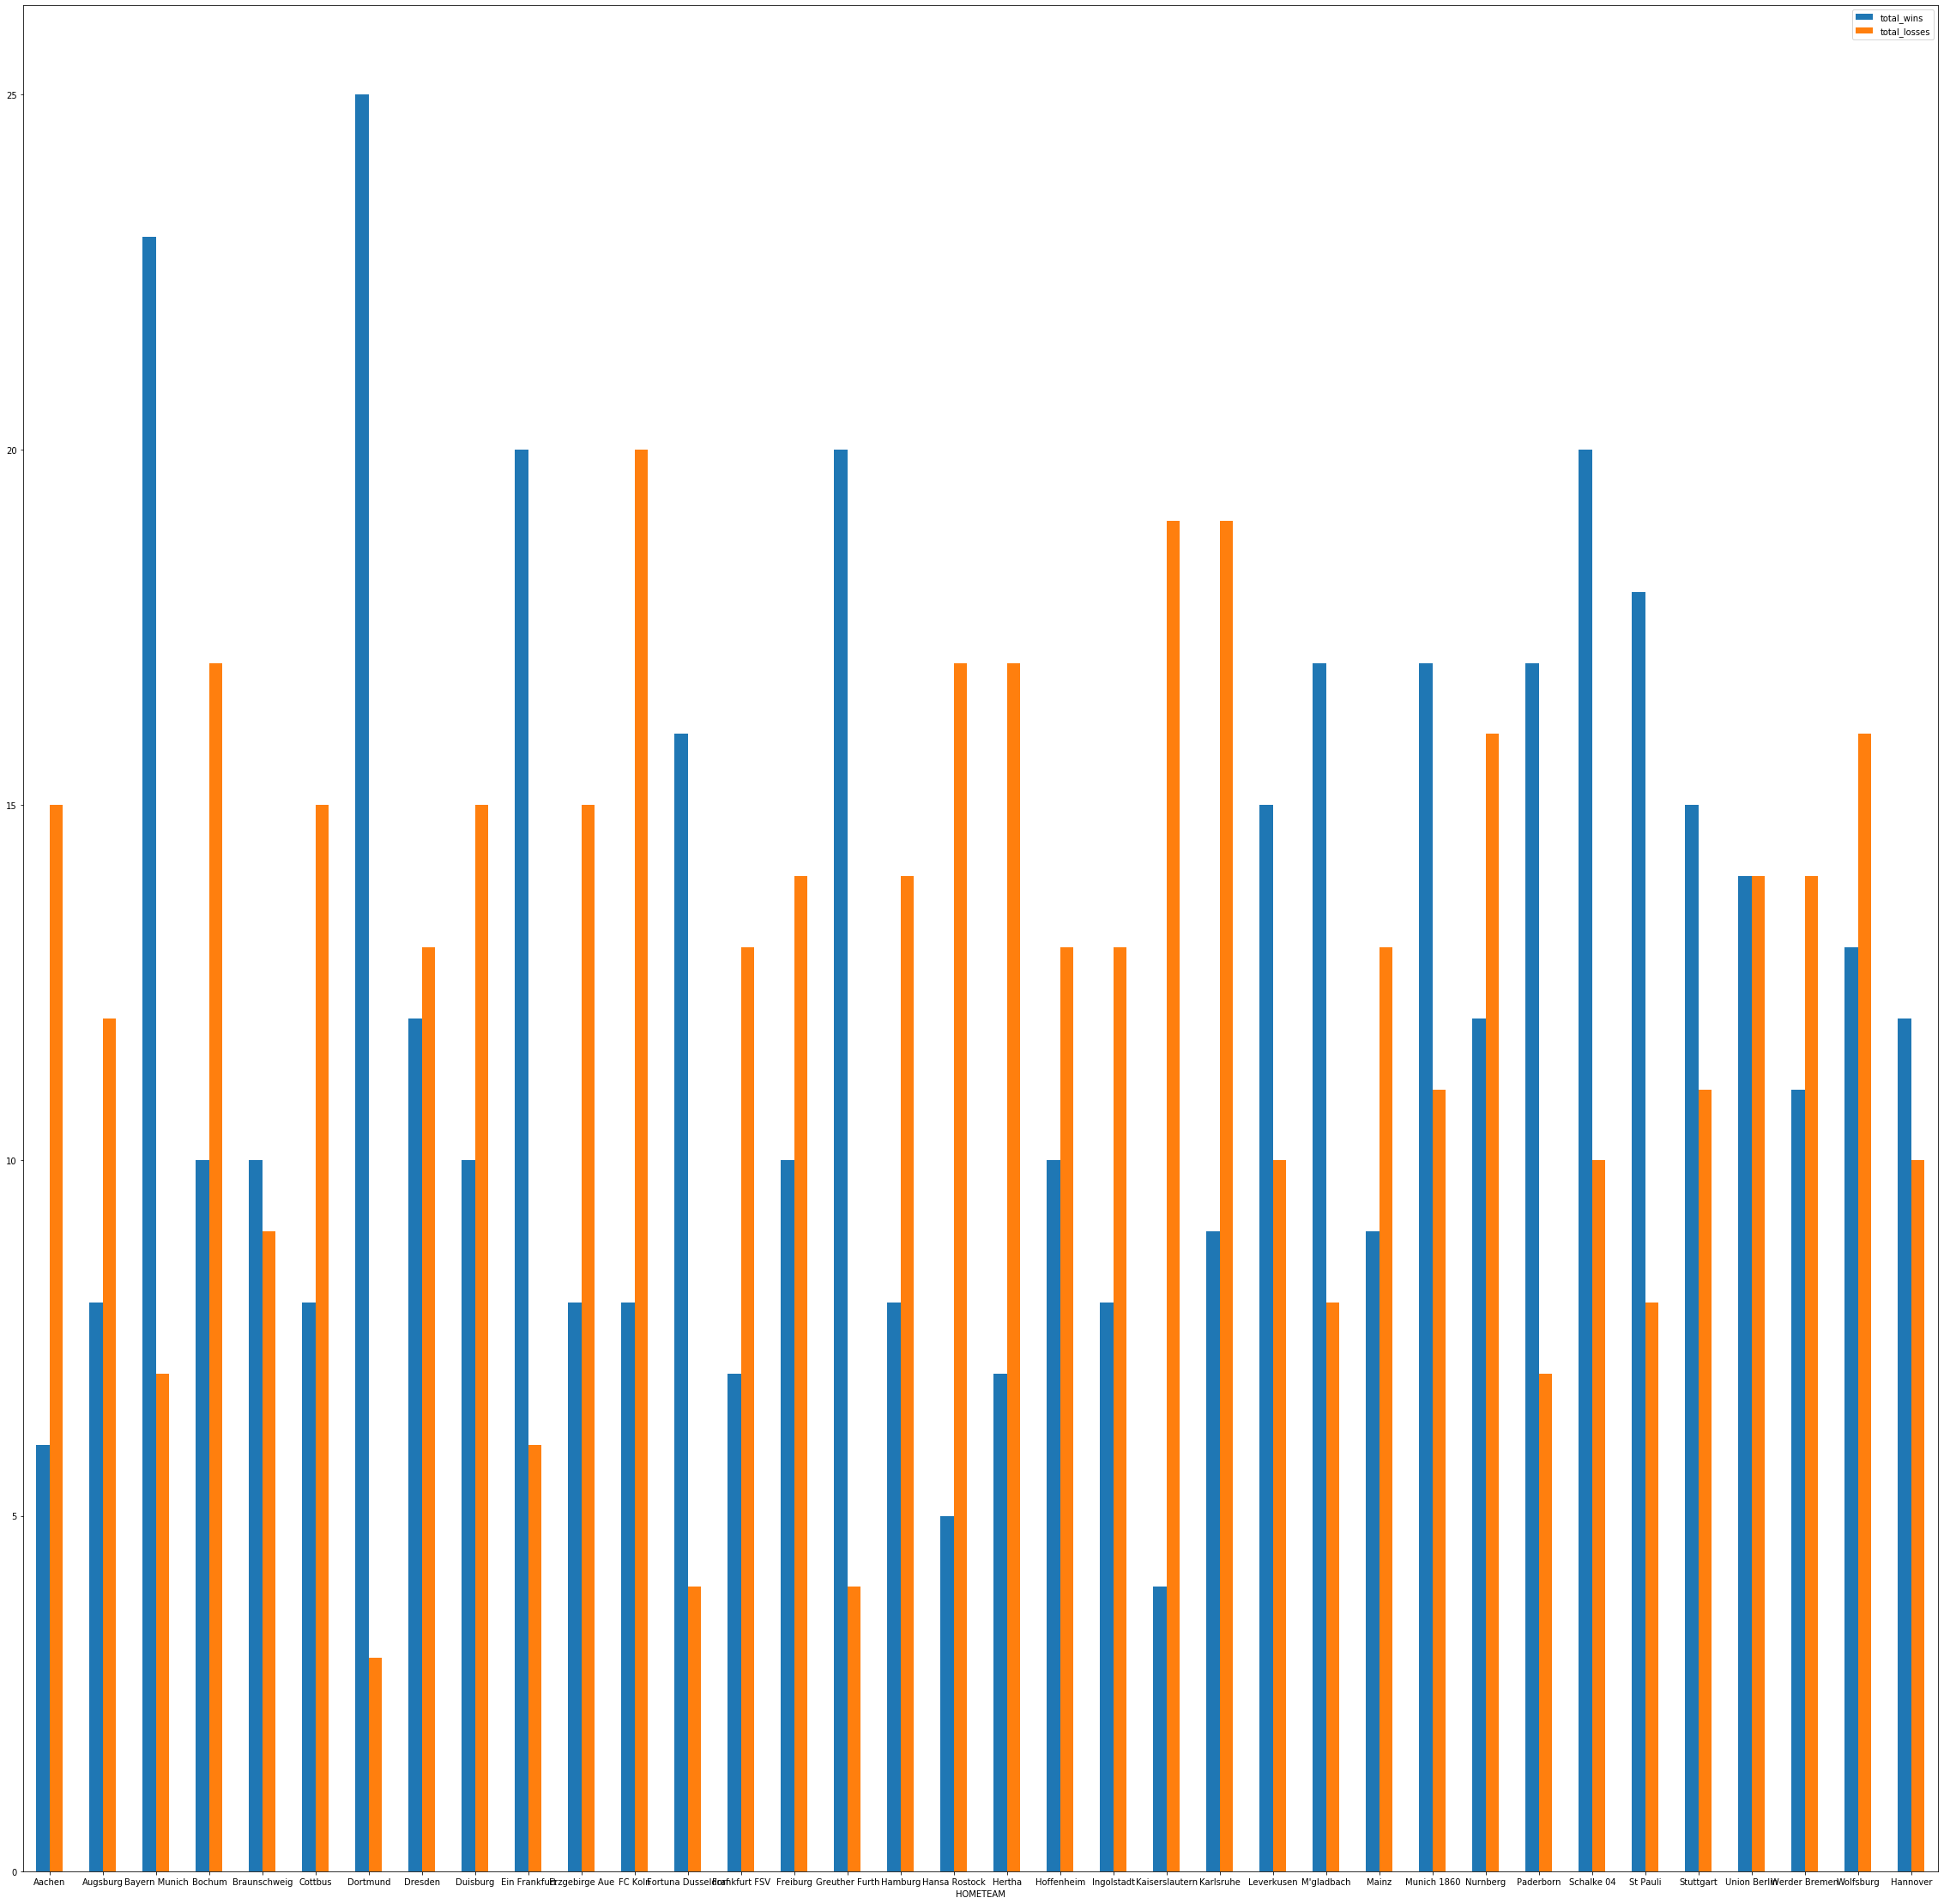

In [154]:
wins = list_wins
losses = list_losses
index = total_wins_losses['HOMETEAM']
df = pd.DataFrame({'total_wins': wins,
                   'total_losses': losses}, index=index)
ax = df.plot.bar(rot=0, figsize = (40,40))


Making this into a dictionary so it can be stored in a mongodb.

In [29]:
goals = total_wins_losses.set_index('HOMETEAM')
total_goals = goals.to_dict()
total_goals

{'home_wins': {'Aachen': 4,
  'Augsburg': 6,
  'Bayern Munich': 14,
  'Bochum': 7,
  'Braunschweig': 6,
  'Cottbus': 4,
  'Dortmund': 14,
  'Dresden': 8,
  'Duisburg': 8,
  'Ein Frankfurt': 11,
  'Erzgebirge Aue': 5,
  'FC Koln': 5,
  'Fortuna Dusseldorf': 11,
  'Frankfurt FSV': 3,
  'Freiburg': 6,
  'Greuther Furth': 14,
  'Hamburg': 3,
  'Hansa Rostock': 3,
  'Hertha': 4,
  'Hoffenheim': 4,
  'Ingolstadt': 6,
  'Kaiserslautern': 2,
  'Karlsruhe': 8,
  'Leverkusen': 8,
  "M'gladbach": 9,
  'Mainz': 7,
  'Munich 1860': 10,
  'Nurnberg': 6,
  'Paderborn': 9,
  'Schalke 04': 13,
  'St Pauli': 12,
  'Stuttgart': 10,
  'Union Berlin': 11,
  'Werder Bremen': 8,
  'Wolfsburg': 10,
  'Hannover': 10},
 'hometeam': {'Aachen': 'Aachen',
  'Augsburg': 'Augsburg',
  'Bayern Munich': 'Bayern Munich',
  'Bochum': 'Bochum',
  'Braunschweig': 'Braunschweig',
  'Cottbus': 'Cottbus',
  'Dortmund': 'Dortmund',
  'Dresden': 'Dresden',
  'Duisburg': 'Duisburg',
  'Ein Frankfurt': 'Ein Frankfurt',
  'Erzgeb

In [30]:
total_wins_losses['total_wins_overall'].max()

25

In [31]:
total_wins_losses['total_wins_overall'].min()

4

The above table tells us the overall wins and losses for each team. The team with the highest number of wins is Dortmund, whereas the team with the least amount of wins is Kaiserslautern.

**Focus: total number of goals scored**

In [32]:
cur.execute("""SELECT DISTINCT HomeTeam as HomeT, SUM(FTHG)
                FROM Matches
                WHERE season = '2011' AND Div != 'E0'
                GROUP BY HomeTeam
                ORDER BY HomeTeam ASC;""")

home_goals= pd.DataFrame(cur.fetchall())

home_goals.columns = [x[0] for x in cur.description]
home_goals

,HomeT,SUM(FTHG)
0,Aachen,15
1,Augsburg,20
2,Bayern Munich,49
3,Bochum,23
4,Braunschweig,21
5,Cottbus,18
6,Dortmund,44
7,Dresden,30
8,Duisburg,23
9,Ein Frankfurt,38


In [33]:
cur.execute("""SELECT DISTINCT AwayTeam as AwayT, SUM(FTAG)
                FROM Matches
                WHERE season = '2011' AND Div != 'E0'
                GROUP BY AwayTeam
                ORDER BY AwayTeam ASC;""")

away_goals= pd.DataFrame(cur.fetchall())

away_goals.columns = [x[0] for x in cur.description]
away_goals

,AwayT,SUM(FTAG)
0,Aachen,15
1,Augsburg,16
2,Bayern Munich,28
3,Bochum,18
4,Braunschweig,16
5,Cottbus,12
6,Dortmund,36
7,Dresden,20
8,Duisburg,19
9,Ein Frankfurt,38


In [34]:
total_goals = pd.concat([home_goals,away_goals], axis = 1)

In [35]:
total_goals

,HomeT,SUM(FTHG),AwayT,SUM(FTAG)
0,Aachen,15,Aachen,15
1,Augsburg,20,Augsburg,16
2,Bayern Munich,49,Bayern Munich,28
3,Bochum,23,Bochum,18
4,Braunschweig,21,Braunschweig,16
5,Cottbus,18,Cottbus,12
6,Dortmund,44,Dortmund,36
7,Dresden,30,Dresden,20
8,Duisburg,23,Duisburg,19
9,Ein Frankfurt,38,Ein Frankfurt,38


In [36]:
total_goals['total'] = total_goals['SUM(FTHG)'] + total_goals['SUM(FTAG)']

In [37]:
total_goals

,HomeT,SUM(FTHG),AwayT,SUM(FTAG),total
0,Aachen,15,Aachen,15,30
1,Augsburg,20,Augsburg,16,36
2,Bayern Munich,49,Bayern Munich,28,77
3,Bochum,23,Bochum,18,41
4,Braunschweig,21,Braunschweig,16,37
5,Cottbus,18,Cottbus,12,30
6,Dortmund,44,Dortmund,36,80
7,Dresden,30,Dresden,20,50
8,Duisburg,23,Duisburg,19,42
9,Ein Frankfurt,38,Ein Frankfurt,38,76


Below is the total number of (home and away) goals scored per team in the bundesliga in 2011.

In [38]:
total_goals.drop(['SUM(FTHG)', 'AwayT', 'SUM(FTAG)'], axis=1)

,HomeT,total
0,Aachen,30
1,Augsburg,36
2,Bayern Munich,77
3,Bochum,41
4,Braunschweig,37
5,Cottbus,30
6,Dortmund,80
7,Dresden,50
8,Duisburg,42
9,Ein Frankfurt,76


Making this table into a dictionary which can then be added to the mongodb.

In [39]:
b = total_goals.set_index('HomeT')
a = b.to_dict()
a

{'SUM(FTHG)': {'Aachen': 15,
  'Augsburg': 20,
  'Bayern Munich': 49,
  'Bochum': 23,
  'Braunschweig': 21,
  'Cottbus': 18,
  'Dortmund': 44,
  'Dresden': 30,
  'Duisburg': 23,
  'Ein Frankfurt': 38,
  'Erzgebirge Aue': 19,
  'FC Koln': 20,
  'Fortuna Dusseldorf': 35,
  'Frankfurt FSV': 20,
  'Freiburg': 24,
  'Greuther Furth': 46,
  'Hamburg': 19,
  'Hannover': 31,
  'Hansa Rostock': 20,
  'Hertha': 19,
  'Hoffenheim': 21,
  'Ingolstadt': 28,
  'Kaiserslautern': 12,
  'Karlsruhe': 23,
  'Leverkusen': 28,
  "M'gladbach": 29,
  'Mainz': 27,
  'Munich 1860': 35,
  'Nurnberg': 22,
  'Paderborn': 28,
  'Schalke 04': 47,
  'St Pauli': 36,
  'Stuttgart': 36,
  'Union Berlin': 30,
  'Werder Bremen': 31,
  'Wolfsburg': 29},
 'AwayT': {'Aachen': 'Aachen',
  'Augsburg': 'Augsburg',
  'Bayern Munich': 'Bayern Munich',
  'Bochum': 'Bochum',
  'Braunschweig': 'Braunschweig',
  'Cottbus': 'Cottbus',
  'Dortmund': 'Dortmund',
  'Dresden': 'Dresden',
  'Duisburg': 'Duisburg',
  'Ein Frankfurt': 'Ein 

**Statistics for use with the team's winning percentage on days when it was raining.**

First, we need to access the Dark Sky API to get historical weather data for the matches. We can append this information to the matches table for all teams in the bundesliga in 2011, and then from there begin to calculate summary statistics.

In [40]:
cur.execute("""SELECT *
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0'
                ORDER BY Date ASC;""")

dates = pd.DataFrame(cur.fetchall())

dates.columns = [x[0] for x in cur.description]
dates

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1133,D2,2011,2011-07-15,Cottbus,Dresden,2,1,H
1,1167,D2,2011,2011-07-15,Greuther Furth,Ein Frankfurt,2,3,A
2,1551,D2,2011,2011-07-15,Frankfurt FSV,Union Berlin,1,1,D
3,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H
4,1678,D2,2011,2011-07-16,St Pauli,Ingolstadt,2,0,H
5,1146,D2,2011,2011-07-17,Karlsruhe,Duisburg,3,2,H
6,1442,D2,2011,2011-07-17,Braunschweig,Munich 1860,3,1,H
7,1602,D2,2011,2011-07-17,Hansa Rostock,Paderborn,1,2,A
8,1360,D2,2011,2011-07-18,Fortuna Dusseldorf,Bochum,2,0,H
9,1505,D2,2011,2011-07-22,Duisburg,Cottbus,1,2,A


This column is the specific column we want to use for the API.

In [41]:
cur.execute("""SELECT DISTINCT Date
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0'
                ORDER BY Date ASC;""")

dates = pd.DataFrame(cur.fetchall())

dates.columns = [x[0] for x in cur.description]
dates

,Date
0,2011-07-15
1,2011-07-16
2,2011-07-17
3,2011-07-18
4,2011-07-22
5,2011-07-23
6,2011-07-24
7,2011-07-25
8,2011-08-05
9,2011-08-06


An initial get request to the API gives us an overview of the returned json file.

In [42]:
import requests

In [43]:
m = requests.get(f"https://api.darksky.net/forecast/85591acf50c4208c767c4eb4b18856a5/52.5200,13.4050,2012-05-06T16:00:00").json()

In [44]:
m

{'latitude': 52.52,
 'longitude': 13.405,
 'timezone': 'Europe/Berlin',
 'currently': {'time': 1336312800,
  'summary': 'Mostly Cloudy',
  'icon': 'partly-cloudy-day',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 51.03,
  'apparentTemperature': 51.03,
  'dewPoint': 37.4,
  'humidity': 0.59,
  'windSpeed': 4,
  'windGust': 4,
  'windBearing': 15,
  'cloudCover': 0.75,
  'uvIndex': 3,
  'visibility': 6.216},
 'hourly': {'summary': 'Possible light rain overnight and in the morning.',
  'icon': 'rain',
  'data': [{'time': 1336255200,
    'summary': 'Mostly Cloudy',
    'icon': 'partly-cloudy-night',
    'precipIntensity': 0,
    'precipProbability': 0,
    'temperature': 43.63,
    'apparentTemperature': 41.02,
    'dewPoint': 38.01,
    'humidity': 0.8,
    'windSpeed': 4.61,
    'windGust': 4.61,
    'windBearing': 0,
    'cloudCover': 0.86,
    'uvIndex': 0,
    'visibility': 6.216},
   {'time': 1336258800,
    'summary': 'Possible Drizzle',
    'icon': 'rain',
   

The 'summary' key within the 'currently' key (two levels down in the dictionary object returned in the json file) contains information about the weather - specifically, whether it is raining or not. We can use these in our get request from the API (when we select for specific dates).

As noted on the Dark Sky overview page for requests, we need to specify the latitude and longitude we are interested in (Berlin) alongside information about the date we are interested in (including year, month, date and a specfic hour). I will use 16h, as this is a common starting time for football matches.

In [45]:
dates_list = []

for i in dates['Date']:
    dates_list.append(i + "T16:00:00")

print(dates_list)

['2011-07-15T16:00:00', '2011-07-16T16:00:00', '2011-07-17T16:00:00', '2011-07-18T16:00:00', '2011-07-22T16:00:00', '2011-07-23T16:00:00', '2011-07-24T16:00:00', '2011-07-25T16:00:00', '2011-08-05T16:00:00', '2011-08-06T16:00:00', '2011-08-07T16:00:00', '2011-08-08T16:00:00', '2011-08-12T16:00:00', '2011-08-13T16:00:00', '2011-08-14T16:00:00', '2011-08-15T16:00:00', '2011-08-19T16:00:00', '2011-08-20T16:00:00', '2011-08-21T16:00:00', '2011-08-22T16:00:00', '2011-08-26T16:00:00', '2011-08-27T16:00:00', '2011-08-28T16:00:00', '2011-08-29T16:00:00', '2011-09-09T16:00:00', '2011-09-10T16:00:00', '2011-09-11T16:00:00', '2011-09-12T16:00:00', '2011-09-16T16:00:00', '2011-09-17T16:00:00', '2011-09-18T16:00:00', '2011-09-19T16:00:00', '2011-09-23T16:00:00', '2011-09-24T16:00:00', '2011-09-25T16:00:00', '2011-09-26T16:00:00', '2011-09-30T16:00:00', '2011-10-01T16:00:00', '2011-10-02T16:00:00', '2011-10-03T16:00:00', '2011-10-14T16:00:00', '2011-10-15T16:00:00', '2011-10-16T16:00:00', '2011-10-1

In [46]:
import json

In [47]:
weather_dates = {}

for date in dates_list:
    call_weather = requests.get(f"https://api.darksky.net/forecast/85591acf50c4208c767c4eb4b18856a5/52.5200,13.4050,{date}").json()
    weather = call_weather['currently']['summary']
    weather_dates[date] = weather
    
weather_dates

{'2011-07-15T16:00:00': 'Mostly Cloudy',
 '2011-07-16T16:00:00': 'Clear',
 '2011-07-17T16:00:00': 'Clear',
 '2011-07-18T16:00:00': 'Partly Cloudy',
 '2011-07-22T16:00:00': 'Light Rain',
 '2011-07-23T16:00:00': 'Mostly Cloudy',
 '2011-07-24T16:00:00': 'Mostly Cloudy',
 '2011-07-25T16:00:00': 'Mostly Cloudy',
 '2011-08-05T16:00:00': 'Mostly Cloudy',
 '2011-08-06T16:00:00': 'Mostly Cloudy',
 '2011-08-07T16:00:00': 'Mostly Cloudy',
 '2011-08-08T16:00:00': 'Light Rain',
 '2011-08-12T16:00:00': 'Mostly Cloudy',
 '2011-08-13T16:00:00': 'Partly Cloudy',
 '2011-08-14T16:00:00': 'Mostly Cloudy',
 '2011-08-15T16:00:00': 'Mostly Cloudy',
 '2011-08-19T16:00:00': 'Partly Cloudy',
 '2011-08-20T16:00:00': 'Clear',
 '2011-08-21T16:00:00': 'Clear',
 '2011-08-22T16:00:00': 'Clear',
 '2011-08-26T16:00:00': 'Clear',
 '2011-08-27T16:00:00': 'Mostly Cloudy',
 '2011-08-28T16:00:00': 'Mostly Cloudy',
 '2011-08-29T16:00:00': 'Possible Drizzle',
 '2011-09-09T16:00:00': 'Mostly Cloudy',
 '2011-09-10T16:00:00': 'M

In [48]:
from collections import Counter 

Counter(weather_dates.values())

Counter({'Mostly Cloudy': 62,
         'Clear': 49,
         'Partly Cloudy': 14,
         'Light Rain': 3,
         'Possible Drizzle': 3,
         'Possible Light Rain': 3,
         'Overcast': 2})

From the above list, 'light rain', 'possible drizzle' and 'possible light rain' will be counted as a rainy day.

Rainy days are as follows:

2011-07-22

2011-08-08

2011-08-29

2011-09-18

2011-12-02

2011-12-03

2011-12-13

2011-12-16

2011-12-18

**Aachen**

fill with weather with 0 then replace dates

In [49]:
cur.execute("""SELECT *
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0' AND HomeTeam = 'Aachen'
                ORDER BY Date ASC;""")

aachen1 = pd.DataFrame(cur.fetchall())

aachen1.columns = [x[0] for x in cur.description]
aachen1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,A
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,A
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,D
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,A
5,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,H
6,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,D
7,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,D
8,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,D
9,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,H


In [50]:
aachen1.loc[:, 'FTR'].replace(['H'], [1], inplace=True)

In [51]:
aachen1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,A
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,A
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,D
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,A
5,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,1
6,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,D
7,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,D
8,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,D
9,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,1


In [52]:
aachen1.loc[:, 'FTR'].replace(['A', 'D'], [0,0], inplace=True)

In [53]:
aachen1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,0
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,0
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,0
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,0
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,0
5,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,1
6,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,0
7,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,0
8,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,0
9,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,1


In [54]:
aachen1['Date'].dtype

dtype('O')

In [55]:
aachen1['weather'] = 0


In [56]:
aachen1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,0,0
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,0,0
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,0,0
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,0,0
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,0,0
5,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,1,0
6,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,0,0
7,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,0,0
8,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,0,0
9,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,1,0


In [57]:
aachen1.loc[aachen1['Date'] == '2011-07-22', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-08-08', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-08-29', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-09-18', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-12-02', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-12-03', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-12-13', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-12-16', 'weather'] = 1
aachen1.loc[aachen1['Date'] == '2011-12-18', 'weather'] = 1

In [58]:
aachen1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,0,0
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,0,0
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,0,0
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,0,1
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,0,0
5,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,1,0
6,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,0,0
7,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,0,0
8,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,0,0
9,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,1,0


In [59]:
aachen1['rainy_wins'] = aachen1['FTR'] + aachen1['weather']

In [60]:
aachen1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,0,0,0
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,0,0,0
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,0,0,0
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,0,1,1
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,0,0,0
5,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,1,0,1
6,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,0,0,0
7,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,0,0,0
8,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,0,0,0
9,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,1,0,1


The 'rainy_wins' column tells us whether there was a win on a day with rain (2), or if there was a win on a day when it wasn't (1), or whether it was simply raining and there was no win (1). We are therefore only interested in the rows where rainy_wins = 2. As we can see above, there are no days when it was raining and Aachen won as the home team.

In [61]:
cur.execute("""SELECT *
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0' AND AwayTeam = 'Aachen'
                ORDER BY Date ASC;""")

aachen2 = pd.DataFrame(cur.fetchall())

aachen2.columns = [x[0] for x in cur.description]
aachen2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H
1,1545,D2,2011,2011-08-05,St Pauli,Aachen,3,1,H
2,1535,D2,2011,2011-08-19,Hansa Rostock,Aachen,0,0,D
3,1537,D2,2011,2011-09-09,Paderborn,Aachen,0,0,D
4,1543,D2,2011,2011-09-24,Union Berlin,Aachen,2,0,H
5,1539,D2,2011,2011-10-16,Dresden,Aachen,1,1,D
6,1548,D2,2011,2011-10-28,Bochum,Aachen,1,0,H
7,1534,D2,2011,2011-11-20,Ein Frankfurt,Aachen,4,3,H
8,1549,D2,2011,2011-11-26,Karlsruhe,Aachen,0,2,A
9,1541,D2,2011,2011-12-18,Braunschweig,Aachen,1,1,D


In [62]:
aachen2.loc[:, 'FTR'].replace(['A'], [1], inplace=True)

In [63]:
aachen2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,H
1,1545,D2,2011,2011-08-05,St Pauli,Aachen,3,1,H
2,1535,D2,2011,2011-08-19,Hansa Rostock,Aachen,0,0,D
3,1537,D2,2011,2011-09-09,Paderborn,Aachen,0,0,D
4,1543,D2,2011,2011-09-24,Union Berlin,Aachen,2,0,H
5,1539,D2,2011,2011-10-16,Dresden,Aachen,1,1,D
6,1548,D2,2011,2011-10-28,Bochum,Aachen,1,0,H
7,1534,D2,2011,2011-11-20,Ein Frankfurt,Aachen,4,3,H
8,1549,D2,2011,2011-11-26,Karlsruhe,Aachen,0,2,1
9,1541,D2,2011,2011-12-18,Braunschweig,Aachen,1,1,D


In [64]:
aachen2.loc[:, 'FTR'].replace(['H', 'D'], [0,0], inplace=True)

In [65]:
aachen2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,0
1,1545,D2,2011,2011-08-05,St Pauli,Aachen,3,1,0
2,1535,D2,2011,2011-08-19,Hansa Rostock,Aachen,0,0,0
3,1537,D2,2011,2011-09-09,Paderborn,Aachen,0,0,0
4,1543,D2,2011,2011-09-24,Union Berlin,Aachen,2,0,0
5,1539,D2,2011,2011-10-16,Dresden,Aachen,1,1,0
6,1548,D2,2011,2011-10-28,Bochum,Aachen,1,0,0
7,1534,D2,2011,2011-11-20,Ein Frankfurt,Aachen,4,3,0
8,1549,D2,2011,2011-11-26,Karlsruhe,Aachen,0,2,1
9,1541,D2,2011,2011-12-18,Braunschweig,Aachen,1,1,0


In [66]:
aachen2['weather'] = 0

In [67]:
aachen2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,0,0
1,1545,D2,2011,2011-08-05,St Pauli,Aachen,3,1,0,0
2,1535,D2,2011,2011-08-19,Hansa Rostock,Aachen,0,0,0,0
3,1537,D2,2011,2011-09-09,Paderborn,Aachen,0,0,0,0
4,1543,D2,2011,2011-09-24,Union Berlin,Aachen,2,0,0,0
5,1539,D2,2011,2011-10-16,Dresden,Aachen,1,1,0,0
6,1548,D2,2011,2011-10-28,Bochum,Aachen,1,0,0,0
7,1534,D2,2011,2011-11-20,Ein Frankfurt,Aachen,4,3,0,0
8,1549,D2,2011,2011-11-26,Karlsruhe,Aachen,0,2,1,0
9,1541,D2,2011,2011-12-18,Braunschweig,Aachen,1,1,0,0


In [68]:
aachen2.loc[aachen2['Date'] == '2011-07-22', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-08-08', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-08-29', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-09-18', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-12-02', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-12-03', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-12-13', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-12-16', 'weather'] = 1
aachen2.loc[aachen2['Date'] == '2011-12-18', 'weather'] = 1

In [69]:
aachen2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,0,0
1,1545,D2,2011,2011-08-05,St Pauli,Aachen,3,1,0,0
2,1535,D2,2011,2011-08-19,Hansa Rostock,Aachen,0,0,0,0
3,1537,D2,2011,2011-09-09,Paderborn,Aachen,0,0,0,0
4,1543,D2,2011,2011-09-24,Union Berlin,Aachen,2,0,0,0
5,1539,D2,2011,2011-10-16,Dresden,Aachen,1,1,0,0
6,1548,D2,2011,2011-10-28,Bochum,Aachen,1,0,0,0
7,1534,D2,2011,2011-11-20,Ein Frankfurt,Aachen,4,3,0,0
8,1549,D2,2011,2011-11-26,Karlsruhe,Aachen,0,2,1,0
9,1541,D2,2011,2011-12-18,Braunschweig,Aachen,1,1,0,1


In [70]:
aachen2['rainy_wins'] = aachen2['FTR'] + aachen2['weather']

In [71]:
aachen2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1550,D2,2011,2011-07-16,Erzgebirge Aue,Aachen,1,0,0,0,0
1,1545,D2,2011,2011-08-05,St Pauli,Aachen,3,1,0,0,0
2,1535,D2,2011,2011-08-19,Hansa Rostock,Aachen,0,0,0,0,0
3,1537,D2,2011,2011-09-09,Paderborn,Aachen,0,0,0,0,0
4,1543,D2,2011,2011-09-24,Union Berlin,Aachen,2,0,0,0,0
5,1539,D2,2011,2011-10-16,Dresden,Aachen,1,1,0,0,0
6,1548,D2,2011,2011-10-28,Bochum,Aachen,1,0,0,0,0
7,1534,D2,2011,2011-11-20,Ein Frankfurt,Aachen,4,3,0,0,0
8,1549,D2,2011,2011-11-26,Karlsruhe,Aachen,0,2,1,0,1
9,1541,D2,2011,2011-12-18,Braunschweig,Aachen,1,1,0,1,1


In [72]:
aachen_full = aachen1.append(aachen2, ignore_index=True)

In [73]:
aachen_full

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,0,0,0
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,0,0,0
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,0,0,0
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,0,1,1
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,0,0,0
5,1682,D2,2011,2011-10-23,Aachen,Ingolstadt,3,1,1,0,1
6,1148,D2,2011,2011-11-06,Aachen,Duisburg,2,2,0,0,0
7,1446,D2,2011,2011-12-04,Aachen,Munich 1860,2,2,0,0,0
8,1595,D2,2011,2011-12-11,Aachen,Erzgebirge Aue,1,1,0,0,0
9,1465,D2,2011,2012-02-04,Aachen,St Pauli,2,1,1,0,1


As we can see from the table above, the wins that Aachen has had are all on non-rainy days. Therefore, we can't compare the number of their wins when it has been raining and the number of wins when it hasn't been raining.

**Augsburg**

In [74]:
cur.execute("""SELECT *
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0' AND HomeTeam = 'Augsburg'
                ORDER BY Date ASC;""")

augsberg1 = pd.DataFrame(cur.fetchall())

augsberg1.columns = [x[0] for x in cur.description]
augsberg1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1194,D1,2011,2011-08-06,Augsburg,Freiburg,2,2,D
1,1650,D1,2011,2011-08-20,Augsburg,Hoffenheim,0,2,A
2,1273,D1,2011,2011-09-09,Augsburg,Leverkusen,1,4,A
3,1368,D1,2011,2011-09-24,Augsburg,Hannover,0,0,D
4,1342,D1,2011,2011-10-21,Augsburg,Werder Bremen,1,1,D
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,A
6,1473,D1,2011,2011-11-26,Augsburg,Wolfsburg,2,0,H
7,1493,D1,2011,2011-12-10,Augsburg,M'gladbach,1,0,H
8,1228,D1,2011,2012-01-28,Augsburg,Kaiserslautern,2,2,D
9,1286,D1,2011,2012-02-12,Augsburg,Nurnberg,0,0,D


In [75]:
augsberg1.loc[:, 'FTR'].replace(['H'], [1], inplace=True)

In [76]:
augsberg1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1194,D1,2011,2011-08-06,Augsburg,Freiburg,2,2,D
1,1650,D1,2011,2011-08-20,Augsburg,Hoffenheim,0,2,A
2,1273,D1,2011,2011-09-09,Augsburg,Leverkusen,1,4,A
3,1368,D1,2011,2011-09-24,Augsburg,Hannover,0,0,D
4,1342,D1,2011,2011-10-21,Augsburg,Werder Bremen,1,1,D
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,A
6,1473,D1,2011,2011-11-26,Augsburg,Wolfsburg,2,0,1
7,1493,D1,2011,2011-12-10,Augsburg,M'gladbach,1,0,1
8,1228,D1,2011,2012-01-28,Augsburg,Kaiserslautern,2,2,D
9,1286,D1,2011,2012-02-12,Augsburg,Nurnberg,0,0,D


In [77]:
augsberg1.loc[:, 'FTR'].replace(['A', 'D'], [0,0], inplace=True)

In [78]:
augsberg1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1194,D1,2011,2011-08-06,Augsburg,Freiburg,2,2,0
1,1650,D1,2011,2011-08-20,Augsburg,Hoffenheim,0,2,0
2,1273,D1,2011,2011-09-09,Augsburg,Leverkusen,1,4,0
3,1368,D1,2011,2011-09-24,Augsburg,Hannover,0,0,0
4,1342,D1,2011,2011-10-21,Augsburg,Werder Bremen,1,1,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,0
6,1473,D1,2011,2011-11-26,Augsburg,Wolfsburg,2,0,1
7,1493,D1,2011,2011-12-10,Augsburg,M'gladbach,1,0,1
8,1228,D1,2011,2012-01-28,Augsburg,Kaiserslautern,2,2,0
9,1286,D1,2011,2012-02-12,Augsburg,Nurnberg,0,0,0


In [79]:
augsberg1['weather'] = 0

In [80]:
augsberg1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1194,D1,2011,2011-08-06,Augsburg,Freiburg,2,2,0,0
1,1650,D1,2011,2011-08-20,Augsburg,Hoffenheim,0,2,0,0
2,1273,D1,2011,2011-09-09,Augsburg,Leverkusen,1,4,0,0
3,1368,D1,2011,2011-09-24,Augsburg,Hannover,0,0,0,0
4,1342,D1,2011,2011-10-21,Augsburg,Werder Bremen,1,1,0,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,0,0
6,1473,D1,2011,2011-11-26,Augsburg,Wolfsburg,2,0,1,0
7,1493,D1,2011,2011-12-10,Augsburg,M'gladbach,1,0,1,0
8,1228,D1,2011,2012-01-28,Augsburg,Kaiserslautern,2,2,0,0
9,1286,D1,2011,2012-02-12,Augsburg,Nurnberg,0,0,0,0


In [81]:
augsberg1.loc[augsberg1['Date'] == '2011-07-22', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-08-08', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-08-29', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-09-18', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-12-02', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-12-03', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-12-13', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-12-16', 'weather'] = 1
augsberg1.loc[augsberg1['Date'] == '2011-12-18', 'weather'] = 1

In [82]:
augsberg1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1194,D1,2011,2011-08-06,Augsburg,Freiburg,2,2,0,0
1,1650,D1,2011,2011-08-20,Augsburg,Hoffenheim,0,2,0,0
2,1273,D1,2011,2011-09-09,Augsburg,Leverkusen,1,4,0,0
3,1368,D1,2011,2011-09-24,Augsburg,Hannover,0,0,0,0
4,1342,D1,2011,2011-10-21,Augsburg,Werder Bremen,1,1,0,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,0,0
6,1473,D1,2011,2011-11-26,Augsburg,Wolfsburg,2,0,1,0
7,1493,D1,2011,2011-12-10,Augsburg,M'gladbach,1,0,1,0
8,1228,D1,2011,2012-01-28,Augsburg,Kaiserslautern,2,2,0,0
9,1286,D1,2011,2012-02-12,Augsburg,Nurnberg,0,0,0,0


In [83]:
augsberg1['rainy_wins'] = augsberg1['FTR'] + augsberg1['weather']

In [84]:
augsberg1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1194,D1,2011,2011-08-06,Augsburg,Freiburg,2,2,0,0,0
1,1650,D1,2011,2011-08-20,Augsburg,Hoffenheim,0,2,0,0,0
2,1273,D1,2011,2011-09-09,Augsburg,Leverkusen,1,4,0,0,0
3,1368,D1,2011,2011-09-24,Augsburg,Hannover,0,0,0,0,0
4,1342,D1,2011,2011-10-21,Augsburg,Werder Bremen,1,1,0,0,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,0,0,0
6,1473,D1,2011,2011-11-26,Augsburg,Wolfsburg,2,0,1,0,1
7,1493,D1,2011,2011-12-10,Augsburg,M'gladbach,1,0,1,0,1
8,1228,D1,2011,2012-01-28,Augsburg,Kaiserslautern,2,2,0,0,0
9,1286,D1,2011,2012-02-12,Augsburg,Nurnberg,0,0,0,0,0


We can see that Augsberg did not have any wins on rainy days when they were the home team.

In [85]:
cur.execute("""SELECT *
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0' AND AwayTeam = 'Augsburg'
                ORDER BY Date ASC;""")

augsberg2 = pd.DataFrame(cur.fetchall())

augsberg2.columns = [x[0] for x in cur.description]
augsberg2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1633,D1,2011,2011-08-14,Kaiserslautern,Augsburg,1,1,D
1,1619,D1,2011,2011-08-27,Nurnberg,Augsburg,1,0,H
2,1629,D1,2011,2011-09-17,Hertha,Augsburg,2,2,D
3,1634,D1,2011,2011-10-01,Dortmund,Augsburg,4,0,H
4,1630,D1,2011,2011-10-15,Mainz,Augsburg,0,1,A
5,1626,D1,2011,2011-10-30,FC Koln,Augsburg,3,0,H
6,1621,D1,2011,2011-11-20,Stuttgart,Augsburg,2,1,H
7,1627,D1,2011,2011-12-04,Schalke 04,Augsburg,3,1,H
8,1622,D1,2011,2011-12-17,Hamburg,Augsburg,1,1,D
9,1635,D1,2011,2012-01-21,Freiburg,Augsburg,1,0,H


In [86]:
augsberg2.loc[:, 'FTR'].replace(['A'], [1], inplace=True)

In [87]:
augsberg2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1633,D1,2011,2011-08-14,Kaiserslautern,Augsburg,1,1,D
1,1619,D1,2011,2011-08-27,Nurnberg,Augsburg,1,0,H
2,1629,D1,2011,2011-09-17,Hertha,Augsburg,2,2,D
3,1634,D1,2011,2011-10-01,Dortmund,Augsburg,4,0,H
4,1630,D1,2011,2011-10-15,Mainz,Augsburg,0,1,1
5,1626,D1,2011,2011-10-30,FC Koln,Augsburg,3,0,H
6,1621,D1,2011,2011-11-20,Stuttgart,Augsburg,2,1,H
7,1627,D1,2011,2011-12-04,Schalke 04,Augsburg,3,1,H
8,1622,D1,2011,2011-12-17,Hamburg,Augsburg,1,1,D
9,1635,D1,2011,2012-01-21,Freiburg,Augsburg,1,0,H


In [88]:
augsberg2.loc[:, 'FTR'].replace(['H', 'D'], [0,0], inplace=True)

In [89]:
augsberg2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1633,D1,2011,2011-08-14,Kaiserslautern,Augsburg,1,1,0
1,1619,D1,2011,2011-08-27,Nurnberg,Augsburg,1,0,0
2,1629,D1,2011,2011-09-17,Hertha,Augsburg,2,2,0
3,1634,D1,2011,2011-10-01,Dortmund,Augsburg,4,0,0
4,1630,D1,2011,2011-10-15,Mainz,Augsburg,0,1,1
5,1626,D1,2011,2011-10-30,FC Koln,Augsburg,3,0,0
6,1621,D1,2011,2011-11-20,Stuttgart,Augsburg,2,1,0
7,1627,D1,2011,2011-12-04,Schalke 04,Augsburg,3,1,0
8,1622,D1,2011,2011-12-17,Hamburg,Augsburg,1,1,0
9,1635,D1,2011,2012-01-21,Freiburg,Augsburg,1,0,0


In [90]:
augsberg2['weather'] = 0

In [91]:
augsberg2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1633,D1,2011,2011-08-14,Kaiserslautern,Augsburg,1,1,0,0
1,1619,D1,2011,2011-08-27,Nurnberg,Augsburg,1,0,0,0
2,1629,D1,2011,2011-09-17,Hertha,Augsburg,2,2,0,0
3,1634,D1,2011,2011-10-01,Dortmund,Augsburg,4,0,0,0
4,1630,D1,2011,2011-10-15,Mainz,Augsburg,0,1,1,0
5,1626,D1,2011,2011-10-30,FC Koln,Augsburg,3,0,0,0
6,1621,D1,2011,2011-11-20,Stuttgart,Augsburg,2,1,0,0
7,1627,D1,2011,2011-12-04,Schalke 04,Augsburg,3,1,0,0
8,1622,D1,2011,2011-12-17,Hamburg,Augsburg,1,1,0,0
9,1635,D1,2011,2012-01-21,Freiburg,Augsburg,1,0,0,0


In [92]:
augsberg2.loc[augsberg2['Date'] == '2011-07-22', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-08-08', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-08-29', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-09-18', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-12-02', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-12-03', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-12-13', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-12-16', 'weather'] = 1
augsberg2.loc[augsberg2['Date'] == '2011-12-18', 'weather'] = 1

In [93]:
augsberg2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1633,D1,2011,2011-08-14,Kaiserslautern,Augsburg,1,1,0,0
1,1619,D1,2011,2011-08-27,Nurnberg,Augsburg,1,0,0,0
2,1629,D1,2011,2011-09-17,Hertha,Augsburg,2,2,0,0
3,1634,D1,2011,2011-10-01,Dortmund,Augsburg,4,0,0,0
4,1630,D1,2011,2011-10-15,Mainz,Augsburg,0,1,1,0
5,1626,D1,2011,2011-10-30,FC Koln,Augsburg,3,0,0,0
6,1621,D1,2011,2011-11-20,Stuttgart,Augsburg,2,1,0,0
7,1627,D1,2011,2011-12-04,Schalke 04,Augsburg,3,1,0,0
8,1622,D1,2011,2011-12-17,Hamburg,Augsburg,1,1,0,0
9,1635,D1,2011,2012-01-21,Freiburg,Augsburg,1,0,0,0


In [94]:
augsberg2['rainy_wins'] = augsberg2['FTR'] + augsberg2['weather']

In [95]:
augsberg2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1633,D1,2011,2011-08-14,Kaiserslautern,Augsburg,1,1,0,0,0
1,1619,D1,2011,2011-08-27,Nurnberg,Augsburg,1,0,0,0,0
2,1629,D1,2011,2011-09-17,Hertha,Augsburg,2,2,0,0,0
3,1634,D1,2011,2011-10-01,Dortmund,Augsburg,4,0,0,0,0
4,1630,D1,2011,2011-10-15,Mainz,Augsburg,0,1,1,0,1
5,1626,D1,2011,2011-10-30,FC Koln,Augsburg,3,0,0,0,0
6,1621,D1,2011,2011-11-20,Stuttgart,Augsburg,2,1,0,0,0
7,1627,D1,2011,2011-12-04,Schalke 04,Augsburg,3,1,0,0,0
8,1622,D1,2011,2011-12-17,Hamburg,Augsburg,1,1,0,0,0
9,1635,D1,2011,2012-01-21,Freiburg,Augsburg,1,0,0,0,0


In [96]:
augsberg_full = augsberg1.append(augsberg2, ignore_index=True)

In [97]:
augsberg_full

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1194,D1,2011,2011-08-06,Augsburg,Freiburg,2,2,0,0,0
1,1650,D1,2011,2011-08-20,Augsburg,Hoffenheim,0,2,0,0,0
2,1273,D1,2011,2011-09-09,Augsburg,Leverkusen,1,4,0,0,0
3,1368,D1,2011,2011-09-24,Augsburg,Hannover,0,0,0,0,0
4,1342,D1,2011,2011-10-21,Augsburg,Werder Bremen,1,1,0,0,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,0,0,0
6,1473,D1,2011,2011-11-26,Augsburg,Wolfsburg,2,0,1,0,1
7,1493,D1,2011,2011-12-10,Augsburg,M'gladbach,1,0,1,0,1
8,1228,D1,2011,2012-01-28,Augsburg,Kaiserslautern,2,2,0,0,0
9,1286,D1,2011,2012-02-12,Augsburg,Nurnberg,0,0,0,0,0


The table above tells us that there were no days when it was raining and Augsberg won.

**Bayern Munich**

In [98]:
cur.execute("""SELECT *
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0' AND HomeTeam = 'Bayern Munich'
                ORDER BY Date ASC;""")

bayernmunich1 = pd.DataFrame(cur.fetchall())

bayernmunich1.columns = [x[0] for x in cur.description]
bayernmunich1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1491,D1,2011,2011-08-07,Bayern Munich,M'gladbach,0,1,A
1,1211,D1,2011,2011-08-20,Bayern Munich,Hamburg,5,0,H
2,1197,D1,2011,2011-09-10,Bayern Munich,Freiburg,7,0,H
3,1262,D1,2011,2011-09-24,Bayern Munich,Leverkusen,3,0,H
4,1401,D1,2011,2011-10-15,Bayern Munich,Hertha,4,0,H
5,1293,D1,2011,2011-10-29,Bayern Munich,Nurnberg,4,0,H
6,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,A
7,1335,D1,2011,2011-12-03,Bayern Munich,Werder Bremen,4,1,H
8,1178,D1,2011,2011-12-16,Bayern Munich,FC Koln,3,0,H
9,1481,D1,2011,2012-01-28,Bayern Munich,Wolfsburg,2,0,H


In [99]:
bayernmunich1.loc[:, 'FTR'].replace(['H'], [1], inplace=True)

In [100]:
bayernmunich1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1491,D1,2011,2011-08-07,Bayern Munich,M'gladbach,0,1,A
1,1211,D1,2011,2011-08-20,Bayern Munich,Hamburg,5,0,1
2,1197,D1,2011,2011-09-10,Bayern Munich,Freiburg,7,0,1
3,1262,D1,2011,2011-09-24,Bayern Munich,Leverkusen,3,0,1
4,1401,D1,2011,2011-10-15,Bayern Munich,Hertha,4,0,1
5,1293,D1,2011,2011-10-29,Bayern Munich,Nurnberg,4,0,1
6,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,A
7,1335,D1,2011,2011-12-03,Bayern Munich,Werder Bremen,4,1,1
8,1178,D1,2011,2011-12-16,Bayern Munich,FC Koln,3,0,1
9,1481,D1,2011,2012-01-28,Bayern Munich,Wolfsburg,2,0,1


In [101]:
bayernmunich1.loc[:, 'FTR'].replace(['A', 'D'], [0,0], inplace=True)

In [102]:
bayernmunich1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1491,D1,2011,2011-08-07,Bayern Munich,M'gladbach,0,1,0
1,1211,D1,2011,2011-08-20,Bayern Munich,Hamburg,5,0,1
2,1197,D1,2011,2011-09-10,Bayern Munich,Freiburg,7,0,1
3,1262,D1,2011,2011-09-24,Bayern Munich,Leverkusen,3,0,1
4,1401,D1,2011,2011-10-15,Bayern Munich,Hertha,4,0,1
5,1293,D1,2011,2011-10-29,Bayern Munich,Nurnberg,4,0,1
6,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,0
7,1335,D1,2011,2011-12-03,Bayern Munich,Werder Bremen,4,1,1
8,1178,D1,2011,2011-12-16,Bayern Munich,FC Koln,3,0,1
9,1481,D1,2011,2012-01-28,Bayern Munich,Wolfsburg,2,0,1


In [103]:
bayernmunich1['weather'] = 0

In [104]:
bayernmunich1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1491,D1,2011,2011-08-07,Bayern Munich,M'gladbach,0,1,0,0
1,1211,D1,2011,2011-08-20,Bayern Munich,Hamburg,5,0,1,0
2,1197,D1,2011,2011-09-10,Bayern Munich,Freiburg,7,0,1,0
3,1262,D1,2011,2011-09-24,Bayern Munich,Leverkusen,3,0,1,0
4,1401,D1,2011,2011-10-15,Bayern Munich,Hertha,4,0,1,0
5,1293,D1,2011,2011-10-29,Bayern Munich,Nurnberg,4,0,1,0
6,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,0,0
7,1335,D1,2011,2011-12-03,Bayern Munich,Werder Bremen,4,1,1,0
8,1178,D1,2011,2011-12-16,Bayern Munich,FC Koln,3,0,1,0
9,1481,D1,2011,2012-01-28,Bayern Munich,Wolfsburg,2,0,1,0


In [105]:
bayernmunich1.loc[bayernmunich1['Date'] == '2011-07-22', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-08-08', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-08-29', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-09-18', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-12-02', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-12-03', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-12-13', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-12-16', 'weather'] = 1
bayernmunich1.loc[bayernmunich1['Date'] == '2011-12-18', 'weather'] = 1

In [106]:
bayernmunich1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1491,D1,2011,2011-08-07,Bayern Munich,M'gladbach,0,1,0,0
1,1211,D1,2011,2011-08-20,Bayern Munich,Hamburg,5,0,1,0
2,1197,D1,2011,2011-09-10,Bayern Munich,Freiburg,7,0,1,0
3,1262,D1,2011,2011-09-24,Bayern Munich,Leverkusen,3,0,1,0
4,1401,D1,2011,2011-10-15,Bayern Munich,Hertha,4,0,1,0
5,1293,D1,2011,2011-10-29,Bayern Munich,Nurnberg,4,0,1,0
6,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,0,0
7,1335,D1,2011,2011-12-03,Bayern Munich,Werder Bremen,4,1,1,1
8,1178,D1,2011,2011-12-16,Bayern Munich,FC Koln,3,0,1,1
9,1481,D1,2011,2012-01-28,Bayern Munich,Wolfsburg,2,0,1,0


In [107]:
bayernmunich1['rainy_wins'] = bayernmunich1['FTR'] + bayernmunich1['weather']

In [108]:
bayernmunich1

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1491,D1,2011,2011-08-07,Bayern Munich,M'gladbach,0,1,0,0,0
1,1211,D1,2011,2011-08-20,Bayern Munich,Hamburg,5,0,1,0,1
2,1197,D1,2011,2011-09-10,Bayern Munich,Freiburg,7,0,1,0,1
3,1262,D1,2011,2011-09-24,Bayern Munich,Leverkusen,3,0,1,0,1
4,1401,D1,2011,2011-10-15,Bayern Munich,Hertha,4,0,1,0,1
5,1293,D1,2011,2011-10-29,Bayern Munich,Nurnberg,4,0,1,0,1
6,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,0,0,0
7,1335,D1,2011,2011-12-03,Bayern Munich,Werder Bremen,4,1,1,1,2
8,1178,D1,2011,2011-12-16,Bayern Munich,FC Koln,3,0,1,1,2
9,1481,D1,2011,2012-01-28,Bayern Munich,Wolfsburg,2,0,1,0,1


From the table above, we can see that Bayern Munich won twice when it was the home team and it was raining.

In [109]:
cur.execute("""SELECT *
                FROM Matches
                WHERE Season = '2011' AND Div != 'E0' AND AwayTeam = 'Bayern Munich'
                ORDER BY Date ASC;""")

bayernmunich2 = pd.DataFrame(cur.fetchall())

bayernmunich2.columns = [x[0] for x in cur.description]
bayernmunich2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
1,1104,D1,2011,2011-08-27,Kaiserslautern,Bayern Munich,0,3,A
2,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,A
3,1102,D1,2011,2011-10-01,Hoffenheim,Bayern Munich,0,0,D
4,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,H
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,A
6,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
7,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
8,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H
9,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,D


In [110]:
bayernmunich2.loc[:, 'FTR'].replace(['A'], [1], inplace=True)

In [111]:
bayernmunich2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,1
1,1104,D1,2011,2011-08-27,Kaiserslautern,Bayern Munich,0,3,1
2,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,1
3,1102,D1,2011,2011-10-01,Hoffenheim,Bayern Munich,0,0,D
4,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,H
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,1
6,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
7,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,1
8,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H
9,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,D


In [112]:
bayernmunich2.loc[:, 'FTR'].replace(['H', 'D'], [0,0], inplace=True)

In [113]:
bayernmunich2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,1
1,1104,D1,2011,2011-08-27,Kaiserslautern,Bayern Munich,0,3,1
2,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,1
3,1102,D1,2011,2011-10-01,Hoffenheim,Bayern Munich,0,0,0
4,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,1
6,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,0
7,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,1
8,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,0
9,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,0


In [114]:
bayernmunich2['weather'] = 0

In [115]:
bayernmunich2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,1,0
1,1104,D1,2011,2011-08-27,Kaiserslautern,Bayern Munich,0,3,1,0
2,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,1,0
3,1102,D1,2011,2011-10-01,Hoffenheim,Bayern Munich,0,0,0,0
4,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,0,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,1,0
6,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,0,0
7,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,1,0
8,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,0,0
9,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,0,0


In [116]:
bayernmunich2.loc[bayernmunich2['Date'] == '2011-07-22', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-08-08', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-08-29', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-09-18', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-12-02', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-12-03', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-12-13', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-12-16', 'weather'] = 1
bayernmunich2.loc[bayernmunich2['Date'] == '2011-12-18', 'weather'] = 1

In [117]:
bayernmunich2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather
0,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,1,0
1,1104,D1,2011,2011-08-27,Kaiserslautern,Bayern Munich,0,3,1,0
2,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,1,1
3,1102,D1,2011,2011-10-01,Hoffenheim,Bayern Munich,0,0,0,0
4,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,0,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,1,0
6,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,0,0
7,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,1,0
8,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,0,0
9,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,0,0


In [118]:
bayernmunich2['rainy_wins'] = bayernmunich2['FTR'] + bayernmunich2['weather']

In [119]:
bayernmunich2

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,1,0,1
1,1104,D1,2011,2011-08-27,Kaiserslautern,Bayern Munich,0,3,1,0,1
2,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,1,1,2
3,1102,D1,2011,2011-10-01,Hoffenheim,Bayern Munich,0,0,0,0,0
4,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,0,0,0
5,1106,D1,2011,2011-11-06,Augsburg,Bayern Munich,1,2,1,0,1
6,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,0,0,0
7,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,1,0,1
8,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,0,0,0
9,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,0,0,0


We can see that Bayern Munich won twice when it was the away team and it was raining.

In [120]:
bayernmunich_full = bayernmunich1.append(bayernmunich2, ignore_index=True)

In [121]:
bayernmunich_full

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,weather,rainy_wins
0,1491,D1,2011,2011-08-07,Bayern Munich,M'gladbach,0,1,0,0,0
1,1211,D1,2011,2011-08-20,Bayern Munich,Hamburg,5,0,1,0,1
2,1197,D1,2011,2011-09-10,Bayern Munich,Freiburg,7,0,1,0,1
3,1262,D1,2011,2011-09-24,Bayern Munich,Leverkusen,3,0,1,0,1
4,1401,D1,2011,2011-10-15,Bayern Munich,Hertha,4,0,1,0,1
5,1293,D1,2011,2011-10-29,Bayern Munich,Nurnberg,4,0,1,0,1
6,1122,D1,2011,2011-11-19,Bayern Munich,Dortmund,0,1,0,0,0
7,1335,D1,2011,2011-12-03,Bayern Munich,Werder Bremen,4,1,1,1,2
8,1178,D1,2011,2011-12-16,Bayern Munich,FC Koln,3,0,1,1,2
9,1481,D1,2011,2012-01-28,Bayern Munich,Wolfsburg,2,0,1,0,1


Transferring information to MongoDB

In [122]:
import pymongo

In [123]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['project2_database']

In [124]:
mycollection = mydb['project2_collection']

In [125]:
mycollection.insert_one(a)

'a' is a dictionary created from the total number of goals table above.

In [126]:
a

{'SUM(FTHG)': {'Aachen': 15,
  'Augsburg': 20,
  'Bayern Munich': 49,
  'Bochum': 23,
  'Braunschweig': 21,
  'Cottbus': 18,
  'Dortmund': 44,
  'Dresden': 30,
  'Duisburg': 23,
  'Ein Frankfurt': 38,
  'Erzgebirge Aue': 19,
  'FC Koln': 20,
  'Fortuna Dusseldorf': 35,
  'Frankfurt FSV': 20,
  'Freiburg': 24,
  'Greuther Furth': 46,
  'Hamburg': 19,
  'Hannover': 31,
  'Hansa Rostock': 20,
  'Hertha': 19,
  'Hoffenheim': 21,
  'Ingolstadt': 28,
  'Kaiserslautern': 12,
  'Karlsruhe': 23,
  'Leverkusen': 28,
  "M'gladbach": 29,
  'Mainz': 27,
  'Munich 1860': 35,
  'Nurnberg': 22,
  'Paderborn': 28,
  'Schalke 04': 47,
  'St Pauli': 36,
  'Stuttgart': 36,
  'Union Berlin': 30,
  'Werder Bremen': 31,
  'Wolfsburg': 29},
 'AwayT': {'Aachen': 'Aachen',
  'Augsburg': 'Augsburg',
  'Bayern Munich': 'Bayern Munich',
  'Bochum': 'Bochum',
  'Braunschweig': 'Braunschweig',
  'Cottbus': 'Cottbus',
  'Dortmund': 'Dortmund',
  'Dresden': 'Dresden',
  'Duisburg': 'Duisburg',
  'Ein Frankfurt': 'Ein 

'total_goals' is another dictionary created from the number of total wins and losses for each team. We can create a new list with the 'a' dictionary included alongside the 'total_goals' dictionary and pass this in the 'insert many' method to upload the two dictionaries to the mongodb.

In [127]:
total_goals

,HomeT,SUM(FTHG),AwayT,SUM(FTAG),total
0,Aachen,15,Aachen,15,30
1,Augsburg,20,Augsburg,16,36
2,Bayern Munich,49,Bayern Munich,28,77
3,Bochum,23,Bochum,18,41
4,Braunschweig,21,Braunschweig,16,37
5,Cottbus,18,Cottbus,12,30
6,Dortmund,44,Dortmund,36,80
7,Dresden,30,Dresden,20,50
8,Duisburg,23,Duisburg,19,42
9,Ein Frankfurt,38,Ein Frankfurt,38,76


In [128]:
query = mycollection.find({})
for x in query:
    print(x)

{'_id': ObjectId('5dbc2745c3a8e151cb5d3e09'), 'SUM(FTHG)': {'Aachen': 15, 'Augsburg': 20, 'Bayern Munich': 49, 'Bochum': 23, 'Braunschweig': 21, 'Cottbus': 18, 'Dortmund': 44, 'Dresden': 30, 'Duisburg': 23, 'Ein Frankfurt': 38, 'Erzgebirge Aue': 19, 'FC Koln': 20, 'Fortuna Dusseldorf': 35, 'Frankfurt FSV': 20, 'Freiburg': 24, 'Greuther Furth': 46, 'Hamburg': 19, 'Hannover': 31, 'Hansa Rostock': 20, 'Hertha': 19, 'Hoffenheim': 21, 'Ingolstadt': 28, 'Kaiserslautern': 12, 'Karlsruhe': 23, 'Leverkusen': 28, "M'gladbach": 29, 'Mainz': 27, 'Munich 1860': 35, 'Nurnberg': 22, 'Paderborn': 28, 'Schalke 04': 47, 'St Pauli': 36, 'Stuttgart': 36, 'Union Berlin': 30, 'Werder Bremen': 31, 'Wolfsburg': 29}, 'AwayT': {'Aachen': 'Aachen', 'Augsburg': 'Augsburg', 'Bayern Munich': 'Bayern Munich', 'Bochum': 'Bochum', 'Braunschweig': 'Braunschweig', 'Cottbus': 'Cottbus', 'Dortmund': 'Dortmund', 'Dresden': 'Dresden', 'Duisburg': 'Duisburg', 'Ein Frankfurt': 'Ein Frankfurt', 'Erzgebirge Aue': 'Erzgebirge Au

In [129]:
query = mycollection.find({})
for x in query:
    print(x)

{'_id': ObjectId('5dbc2745c3a8e151cb5d3e09'), 'SUM(FTHG)': {'Aachen': 15, 'Augsburg': 20, 'Bayern Munich': 49, 'Bochum': 23, 'Braunschweig': 21, 'Cottbus': 18, 'Dortmund': 44, 'Dresden': 30, 'Duisburg': 23, 'Ein Frankfurt': 38, 'Erzgebirge Aue': 19, 'FC Koln': 20, 'Fortuna Dusseldorf': 35, 'Frankfurt FSV': 20, 'Freiburg': 24, 'Greuther Furth': 46, 'Hamburg': 19, 'Hannover': 31, 'Hansa Rostock': 20, 'Hertha': 19, 'Hoffenheim': 21, 'Ingolstadt': 28, 'Kaiserslautern': 12, 'Karlsruhe': 23, 'Leverkusen': 28, "M'gladbach": 29, 'Mainz': 27, 'Munich 1860': 35, 'Nurnberg': 22, 'Paderborn': 28, 'Schalke 04': 47, 'St Pauli': 36, 'Stuttgart': 36, 'Union Berlin': 30, 'Werder Bremen': 31, 'Wolfsburg': 29}, 'AwayT': {'Aachen': 'Aachen', 'Augsburg': 'Augsburg', 'Bayern Munich': 'Bayern Munich', 'Bochum': 'Bochum', 'Braunschweig': 'Braunschweig', 'Cottbus': 'Cottbus', 'Dortmund': 'Dortmund', 'Dresden': 'Dresden', 'Duisburg': 'Duisburg', 'Ein Frankfurt': 'Ein Frankfurt', 'Erzgebirge Aue': 'Erzgebirge Au